<a href="https://colab.research.google.com/github/yuxuanzhuang/ENPMDA/blob/main/docs/source/examples/examples.ipynb" target="_parent"><img src=https://colab.research.google.com/assets/colab-badge.svg>

[open in colab](https://colab.research.google.com/github/yuxuanzhuang/ENPMDA/blob/main/docs/source/examples/examples.ipynb)

# ENPMDA Usage

In [1]:
# uncomment these lines if the package is not installed.
# !pip install -e "git+https://github.com/yuxuanzhuang/enpmda"
# !pip install -e "git+https://github.com/yuxuanzhuang/enpmda#subdirectory=tests"
# !pip install IProgress
# !pip install seaborn

In [ ]:
# In colab, only two cores are available.
# To run the examples, you need to use your local runtime:

import numpy as np

import dask
from dask.distributed import Client, LocalCluster

cluster = LocalCluster(n_workers=16, scheduler_port=8786,
                      memory_limit='auto')
client = Client(cluster)
client

## Construct trajectory ensemble

In [3]:
from ENPMDA import MDDataFrame
from ENPMDA.preprocessing import TrajectoryEnsemble
from ENPMDATests.datafiles import (
    ensemble_ala_bonded,
    ensemble_ala_traj,
    ensemble_ala_top
)

In [4]:
# add tmp folder to path for testing
import tempfile
tempdir = tempfile.mkdtemp()

If `only_raw` is set to `False`, preprocessed trajectories for both protein and system will be written in the same directory of the raw trajectory. Define `skip` to skip frames in the written trajectories.

If `only_raw` is set to `True`, no trajectories for protein and system will be extracted and saved. This is good for a quick inspection of on-going raw trajectories. It could also be useful if you already have preprocessed trajectories that need no further coordinate transformations. Note `skip` will be ignored in these cases; define `stride` instead later on when you `add_traj_ensemble` to the dataframe.


Note the speed of on-the-fly transformations is really slow for large systems and I
recommend patching https://github.com/MDAnalysis/mdanalysis/pull/3169
to your MDAnalysis installation.

In [7]:
traj_ensemble = TrajectoryEnsemble(ensemble_name=tempdir + '/test_ensemble',
                                    topology_list=ensemble_ala_top,
                                    trajectory_list=ensemble_ala_traj,
                                    bonded_topology_list=ensemble_ala_bonded,
                                    skip=1,
                                    updating=False,
                                    only_raw=False)
traj_ensemble.load_ensemble()

Both loading and saving can be done in parallel.

![dask task stream for trajectory preprocessing](./preprocessing_traj.png)

## Construct ENPMDA dataframe

In [8]:
md_dataframe = MDDataFrame(dataframe_name=tempdir + '/test_dataframe')

`npartitions` defined how many blocks you want to split your whole ensemble. It could be set to the number of cores you have.
`stride` is the frame interval between two consecutive frames to be analyzed.

In [9]:
md_dataframe.add_traj_ensemble(traj_ensemble,
                               npartitions=16,
                               stride=1)

Dask dataframe generated with 16 partitions


In [10]:
from ENPMDA.analysis import (
    DaskChunkMdanalysis,
    get_rmsd_init,
    get_backbonetorsion,
    get_atomic_position,
    get_protein_hydration,
)

The custom analysis should subclass `DaskChunkMdanalysis` and define `set_feature_info` and `run_analysis`. (Read the documentation of `DaskChunkMdanalysis` for more details.)

The analysis can be a very simple wrapper of the default MDAnalysis analysis, e.g.

In [11]:
from MDAnalysis.analysis.rms import RMSD

class get_rmsd_init(DaskChunkMdanalysis):
    name = 'rmsd_to_init'

    def set_feature_info(self, universe):
        return ['rmsd_to_init']

    def run_analysis(self, universe, start, stop, step):

        name_backbone = universe.select_atoms('backbone')
        rmsd = RMSD(name_backbone, name_backbone).run(start, stop, step)
        return rmsd.results['rmsd'].T[2]

A sanity check will be performed to ensure that the analysis raises no error.

The parallel analysis will be actively done in the background so one can still coding in the notebook.

The name for extracting features later on will be printed.

In [12]:
md_dataframe.add_analysis(get_rmsd_init)
md_dataframe.add_analysis(get_backbonetorsion)
md_dataframe.add_analysis(get_atomic_position)
md_dataframe.add_analysis(get_protein_hydration)

Analysis rmsd_to_init added
Analysis torsion added
Analysis at_position added
Analysis protein_hydration added


All the analysis can be run in parallel.

![dask task stream for analysis](./analysis_parallel.png)

In [13]:
md_dataframe.save('test_analysis')

In [14]:
md_dataframe.dataframe

universe_protein  \
0    /tmp/tmpm0u3v0_s/test_ensemble/_nethome_yzhuan...   
1    /tmp/tmpm0u3v0_s/test_ensemble/_nethome_yzhuan...   
2    /tmp/tmpm0u3v0_s/test_ensemble/_nethome_yzhuan...   
3    /tmp/tmpm0u3v0_s/test_ensemble/_nethome_yzhuan...   
4    /tmp/tmpm0u3v0_s/test_ensemble/_nethome_yzhuan...   
..                                                 ...   
163  /tmp/tmpm0u3v0_s/test_ensemble/_nethome_yzhuan...   
164  /tmp/tmpm0u3v0_s/test_ensemble/_nethome_yzhuan...   
165  /tmp/tmpm0u3v0_s/test_ensemble/_nethome_yzhuan...   
166  /tmp/tmpm0u3v0_s/test_ensemble/_nethome_yzhuan...   
167  /tmp/tmpm0u3v0_s/test_ensemble/_nethome_yzhuan...   

                                       universe_system system  \
0    /tmp/tmpm0u3v0_s/test_ensemble/_nethome_yzhuan...      0   
1    /tmp/tmpm0u3v0_s/test_ensemble/_nethome_yzhuan...      0   
2    /tmp/tmpm0u3v0_s/test_ensemble/_nethome_yzhuan...      0   
3    /tmp/tmpm0u3v0_s/test_ensemble/_nethome_yzhuan...      0   
4    /tmp/tmpm0u3v0_s/test_ensemble/_nethome_yzhuan...      0   
..                                                 ...    ...   
163  /tmp/tmpm0u3v0_s/test_ensemble/_nethome_yzhuan...      7   
164  /tmp/tmpm0u3v0_s/test_ensemble/_nethome_yzhuan...      7   
165  /tmp/tmpm0u3v0_s/test_ensemble/_nethome_yzhuan...      7   
166  /tmp/tmpm0u3v0_s/test_ensemble/_nethome_yzhuan...      7   
167  /tmp/tmpm0u3v0_s/test_ensemble/_nethome_yzhuan...      7   

                                             traj_name  frame  traj_time  \
0    /nethome/yzhuang/git_repo/ENPMDA/tests/ENPMDAT...      0        0.0   
1    /nethome/yzhuang/git_repo/ENPMDA/tests/ENPMDAT...      1        2.0   
2    /nethome/yzhuang/git_repo/ENPMDA/tests/ENPMDAT...      2        4.0   
3    /nethome/yzhuang/git_repo/ENPMDA/tests/ENPMDAT...      3        6.0   
4    /nethome/yzhuang/git_repo/ENPMDA/tests/ENPMDAT...      4        8.0   
..                                                 ...    ...        ...   
163  /nethome/yzhuang/git_repo/ENPMDA/tests/ENPMDAT...     16       32.0   
164  /nethome/yzhuang/git_repo/ENPMDA/tests/ENPMDAT...     17       34.0   
165  /nethome/yzhuang/git_repo/ENPMDA/tests/ENPMDAT...     18       36.0   
166  /nethome/yzhuang/git_repo/ENPMDA/tests/ENPMDAT...     19       38.0   
167  /nethome/yzhuang/git_repo/ENPMDA/tests/ENPMDAT...     20       40.0   

    stride                                       rmsd_to_init  \
0        1  /tmp/tmpm0u3v0_s/test_dataframe//analysis_resu...   
1        1  /tmp/tmpm0u3v0_s/test_dataframe//analysis_resu...   
2        1  /tmp/tmpm0u3v0_s/test_dataframe//analysis_resu...   
3        1  /tmp/tmpm0u3v0_s/test_dataframe//analysis_resu...   
4        1  /tmp/tmpm0u3v0_s/test_dataframe//analysis_resu...   
..     ...                                                ...   
163      1  /tmp/tmpm0u3v0_s/test_dataframe//analysis_resu...   
164      1  /tmp/tmpm0u3v0_s/test_dataframe//analysis_resu...   
165      1  /tmp/tmpm0u3v0_s/test_dataframe//analysis_resu...   
166      1  /tmp/tmpm0u3v0_s/test_dataframe//analysis_resu...   
167      1  /tmp/tmpm0u3v0_s/test_dataframe//analysis_resu...   

                                               torsion  \
0    /tmp/tmpm0u3v0_s/test_dataframe//analysis_resu...   
1    /tmp/tmpm0u3v0_s/test_dataframe//analysis_resu...   
2    /tmp/tmpm0u3v0_s/test_dataframe//analysis_resu...   
3    /tmp/tmpm0u3v0_s/test_dataframe//analysis_resu...   
4    /tmp/tmpm0u3v0_s/test_dataframe//analysis_resu...   
..                                                 ...   
163  /tmp/tmpm0u3v0_s/test_dataframe//analysis_resu...   
164  /tmp/tmpm0u3v0_s/test_dataframe//analysis_resu...   
165  /tmp/tmpm0u3v0_s/test_dataframe//analysis_resu...   
166  /tmp/tmpm0u3v0_s/test_dataframe//analysis_resu...   
167  /tmp/tmpm0u3v0_s/test_dataframe//analysis_resu...   

                                           at_position  \
0    /tmp/tmpm0u3v0_s/test_dataframe//analysis_resu...   
1    /tmp/tmpm0u3v0_s/test_dataframe//analysis_resu..

All the features will be stored in `npy` files.

It can be accessed by `get_feature` function.

It should be used with caution because all the features will be loaded into memory.

In [15]:
feature_dataframe = md_dataframe.get_feature([
                        'torsion',
                        'protein_hydration'
                        ])

In [16]:
feature_dataframe

system                                          traj_name  frame  \
0        0  /nethome/yzhuang/git_repo/ENPMDA/tests/ENPMDAT...      0   
1        0  /nethome/yzhuang/git_repo/ENPMDA/tests/ENPMDAT...      1   
2        0  /nethome/yzhuang/git_repo/ENPMDA/tests/ENPMDAT...      2   
3        0  /nethome/yzhuang/git_repo/ENPMDA/tests/ENPMDAT...      3   
4        0  /nethome/yzhuang/git_repo/ENPMDA/tests/ENPMDAT...      4   
..     ...                                                ...    ...   
163      7  /nethome/yzhuang/git_repo/ENPMDA/tests/ENPMDAT...     16   
164      7  /nethome/yzhuang/git_repo/ENPMDA/tests/ENPMDAT...     17   
165      7  /nethome/yzhuang/git_repo/ENPMDA/tests/ENPMDAT...     18   
166      7  /nethome/yzhuang/git_repo/ENPMDA/tests/ENPMDAT...     19   
167      7  /nethome/yzhuang/git_repo/ENPMDA/tests/ENPMDAT...     20   

     traj_time  0_phi_cos  0_phi_sin  1_psi_cos  1_psi_sin  protein_hydration  
0          0.0  -0.972585   0.232546  -0.850531  -0.525925                 89  
1          2.0  -0.930982   0.365066  -0.182160  -0.983269                 88  
2          4.0  -0.921595   0.388153  -0.672957  -0.739681                 93  
3          6.0  -0.891143   0.453722   0.298339  -0.954460                 94  
4          8.0  -0.774034   0.633144   0.010315  -0.999947                102  
..         ...        ...        ...        ...        ...                ...  
163       32.0  -0.849980   0.526815   0.599313  -0.800515                 97  
164       34.0  -0.828825   0.559508   0.511923  -0.859032                102  
165       36.0  -0.943376   0.331726   0.449359  -0.893351                 91  
166       38.0  -0.335371   0.942086   0.311771  -0.950157                 95  
167       40.0  -0.985048  -0.172282  -0.737555  -0.675287                114  

[168 rows x 9 columns]

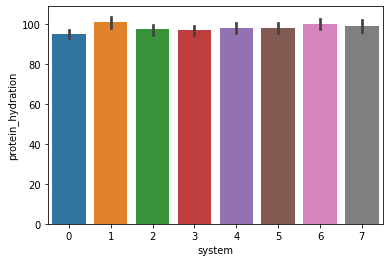

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(data=feature_dataframe,
             x='system',
             y='protein_hydration')
plt.show()

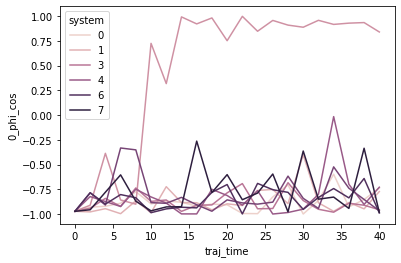

In [18]:
sns.lineplot(data=feature_dataframe,
             x='traj_time',
             y='0_phi_cos',
             hue='system')
plt.show()